# Improving Bank Marketing Campaigns with Machine Learning
### Group 7 - Gary Bair, Hunter Blum, and Jacqueline Urenda
### Github Repo: https://github.com/hunterblum/BusinessFinal

# Background, Problem, and Goals

Term deposits are pivotal to the success of a bank and the overall economy. In these deposits, a customer lends cash to a bank for a set term in return for a small amount of interest. In return, the bank has the liquid assets it needs to give out larger and higher-interest loans, allowing the bank to profit (Kagan, 2020). Because of their importance, banks have been running more direct marketing campaigns in hopes of increasing their cash flow. However, because most customers do not want a term deposit or respond to telemarketing, these direct marketing campaigns that lack clear strategies, waste money, and frustrate uninterested customers (Moro et al., 2014). 

It is in this space that data mining presents a unique opportunity to optimize the organization's efforts when contacting individuals to subscribe to a term deposit and effectively reduce the prevalence of unproductive contacts, reducing labor costs and increasing profits from more successful calls. This analysis aims to validate a variety of industry-leading machine-learning algorithms to determine whether the bank's term deposit subscriptions can be effectively modeled using historical client, contact, and behavioral data. With this goal, this study aims to establish:

1. Whether historical datasets contain sufficient information to promote predictive modeling, ensuring that the data is suitably clean, contains plausible distributions of values, and is free of missing values.

2. Identify key features for predicting the bank's term deposit subscriptions while assessing opportunities for data reduction.

3. Establishing a preprocessing methodology including components such as feature extraction, transformation, and reduction

4. Assess the viability of different families of machine learning algorithms.

5. For the best-performing models, determine the optimal hyperparameters that can be expected to generalize to unseen data.



### Package Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# preprocessing packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

# resampling tools
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

#feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier

#metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

#pandas settings
pd.set_option('display.max_columns', None)

# DMBA packages
from dmba import gainsChart, liftChart

# Exploratory Data Analysis
## Dataset Description

The data for this study was collected by Moro et al. (2014), from a Portuguese retail bank direct marketing campaign spanning from 2008 to 2010. The original authors utilized a two-step feature selection, first having domain experts select relevant features, then employing a forward-feeding model to calculate which relevant features increased AUC (Moro et al., 2014). This feature-selected dataset was donated to the UCI Machine Learning Repository, containing 21 features and 41,188 observations. Our target feature was a binary variable describing if a client set up a term deposit. The predictors included demographic variables (age, job, etc.), banking information (credit defaults, loans, etc.), and other various indicators. 

### *Input variables*:
1. age: Customer Age (numeric)
2. job : Type of Job (categorical)
3. marital : Marital Status (categorical)
4. education: Level of Education (categorical)
5. default: Has credit in default? (categorical)
6. housing: Has housing loan? (categorical)
7. loan: Has personal loan? (categorical)
8. contact: Contact Communication Type (categorical)
9. month: Last Contact Month of Year (categorical)
10. day_of_week: Last Contact Day of the Week (categorical)
11. duration: Last Contact Duration, in seconds (numeric). 
12. campaign: Number of contacts performed during this campaign and for this client which includes last contact(numeric)
13. pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
14. previous: Number of contacts performed before this campaign and for this client (numeric)
15. poutcome: Outcome of previous marketing campaign contacts (categorical)
16. emp.var.rate: Employment Variation Rate - quarterly indicator (numeric)
17. cons.price.idx: Consumer Price Index - monthly indicator (numeric)
18. cons.conf.idx: Consumer Confidence Index - monthly indicator (numeric)
19. euribor3m: Euribor 3 Month Rate - daily indicator (numeric)
20. nr.employed: Number of Employees - quarterly indicator (numeric)

### *Output Variable*:
21. y - has the client subscribed a term deposit? (binary)

There are two significant things to note from the description of the data.
- The duration feature is highly affected by the output target (e.g., if duration=0 then y='no') therefore this feature should be discarded if the intention is to produce a realistic predictive model.
- For the feature pdays, 999 means client was not previously contacted which depending on the model implemented may affect the implementation of this analysis’s preprocessing.

### Data Import

In [2]:
bank = pd.read_csv("bank-additional-full.csv", delimiter=";")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Dataset Description/Structure

In [3]:
# dataset dimensions
print("The data has", bank.shape[1], "features.")
print("The data has", bank.shape[0], "observations.")

The data has 21 features.
The data has 41188 observations.


In [4]:
# feature datatypes
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

## Univariate Analysis
Since the data was pre-cleaned before being donated, there were no missing values. Descriptive statistics were determined to understand the relationships and features in the dataset. Table 1 shows the descriptive statistics including the mean, standard deviation, min, max, and percentiles. The numerical columns were analyzed to determine their distribution. Figure 1 shows histogram charts of each numerical feature. "Duration", "Campaign", and "previous" variables seemed to be  very rightly skewed. Variables  "pdays", "emp.var.rate", and "nr.employed" are heavily left skewed. The skewness of each feature was calculated and "Duration", "campaign", "pdays" and "previous" have the most skewness. Most features appeared to not have a normal distribution. 

Boxplots were used to look at numeric distributions in the dataset to search for potential outliers. We found that “duration” had a large quantity of outliers. Features such as “age”, “campaign”, “pdays”, “previous”, and “cons.conf.idx” had outliers as well (Figure 2). Ultimately, the outliers were kept in the dataset to maintain data representation and improve modeling results. Finally, our target feature was heavily unbalanced, with only 11.27% of observations answering "yes." To combat the performance issues from this imbalance, we will utilize random undersampling to create an even target distribution. 


In [5]:
# counts of unique labels
bank.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [6]:
# missing data
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

After partitioning by each feature, explicit missing data is not present thus imputation will not be required.

In [7]:
# descriptive stats:
print("Table 1: Descriptive Statistics for Numeric Predictors")
bank.describe()

Table 1: Descriptive Statistics for Numeric Predictors


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


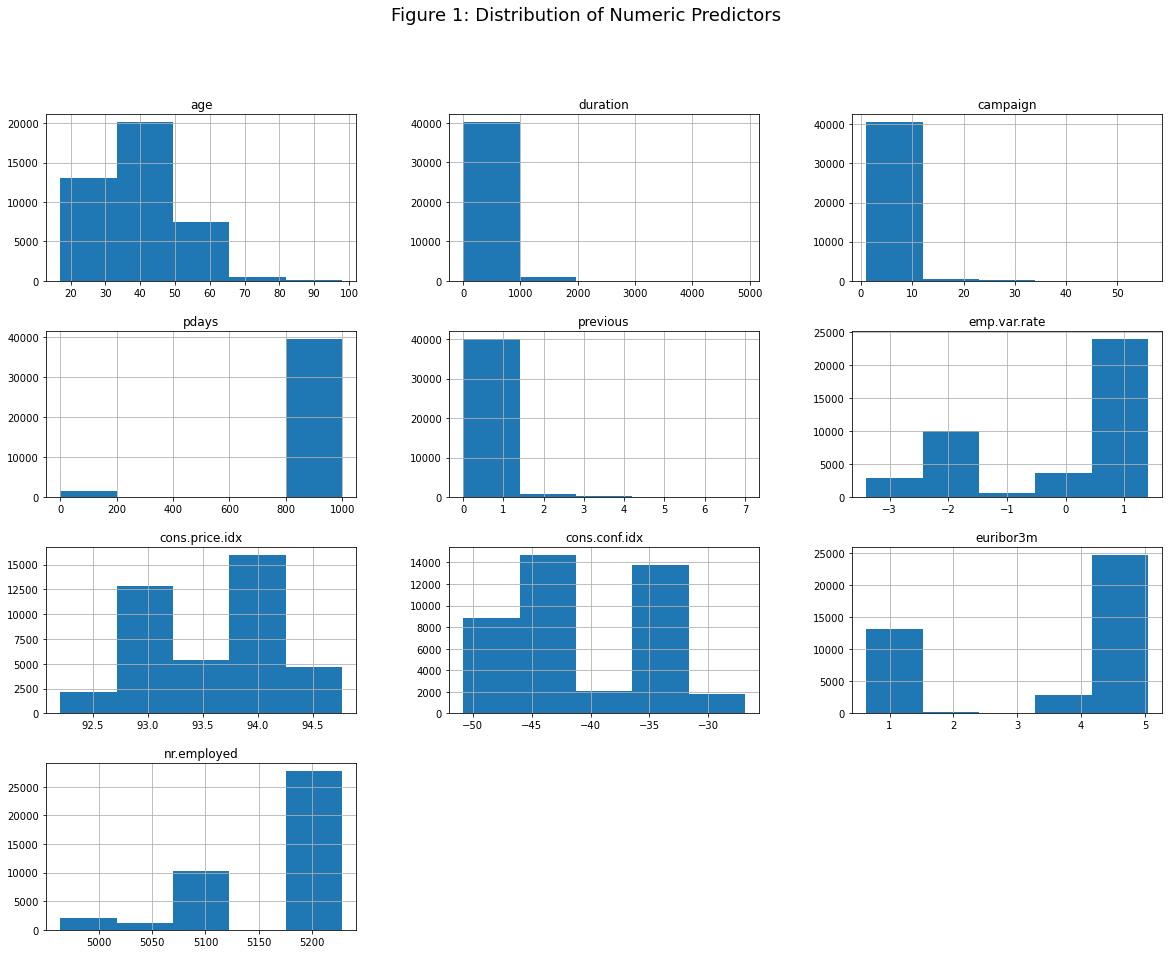

In [8]:
# distribution of numerical features
bank.hist(figsize=(20,15),bins=5)
plt.suptitle("Figure 1: Distribution of Numeric Predictors", fontsize = 18)
plt.show()

"Age" seems most normally distributed but still appears to be right skewed. "Duration", "Campaign", and "previous" variables seem very rightly skewed. "pdays", "emp.var.rate", and "nr.employed" are heavily left skewed. Several variables don't have a normal distribution.

In [9]:
# calculating the skewness of numeric features
bank.skew()

age               0.784697
duration          3.263141
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

"Duration", "campaign", "pdays" and "previous" have the most skewness

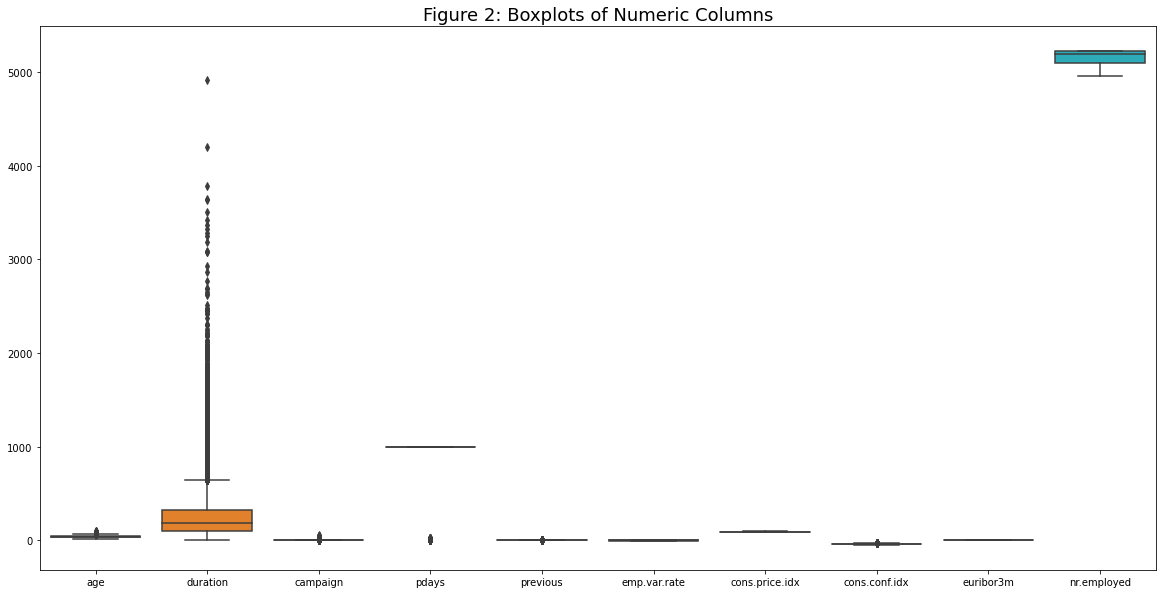

In [10]:
# outlier analysis
plt.figure(figsize=(20,10))
sns.boxplot(data = bank);
plt.title('Figure 2: Boxplots of Numeric Columns', fontsize = 18)
plt.show()

Boxplots show outliers in "duration", "campaign", "pdays", "previous" and "con.price.idx"

In [11]:
#identify
y_count = bank.groupby(['y'])['y'].count()
yes_per = round(y_count.yes/bank.shape[0]*100,2)
no_per = round(y_count.no/bank.shape[0]*100,2)

print(y_count.yes, "(" + str(yes_per) + "%)", "of observations responded yes to a term deposit")
print(y_count.no, "(" + str(no_per) + "%)", "of observations responded no to a term deposit")


4640 (11.27%) of observations responded yes to a term deposit
36548 (88.73%) of observations responded no to a term deposit


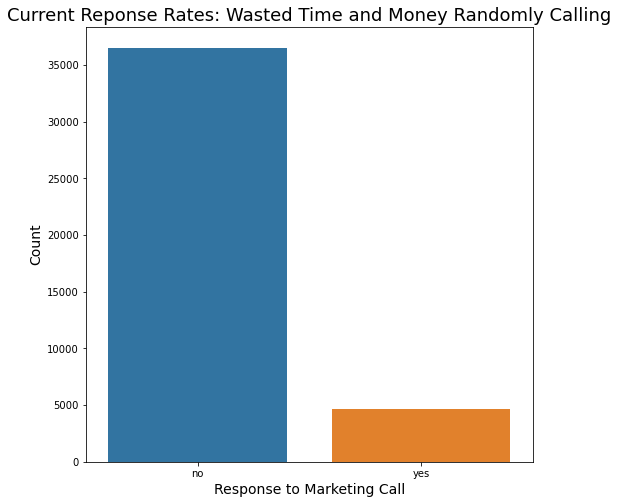

In [44]:
sns.countplot(x = bank['y'])
plt.title("Current Reponse Rates: Wasted Time and Money Randomly Calling", fontsize = 18)
plt.xlabel("Response to Marketing Call", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.gcf().set_size_inches(8,8)
plt.show()

In [19]:
# identify prior customers likehood to subscribe
prior_cust = bank[bank['poutcome']=='success']

y_count = prior_cust.groupby(['y'])['y'].count()
yes_per = round(y_count.yes/prior_cust.shape[0]*100,2)
no_per = round(y_count.no/prior_cust.shape[0]*100,2)

print(y_count.yes, "(" + str(yes_per) + "%)", "of prior customers responded yes to a term deposit")
print(y_count.no, "(" + str(no_per) + "%)", "of prior customers responded no to a term deposit")

894 (65.11%) of prior customers responded yes to a term deposit
479 (34.89%) of prior customers responded no to a term deposit


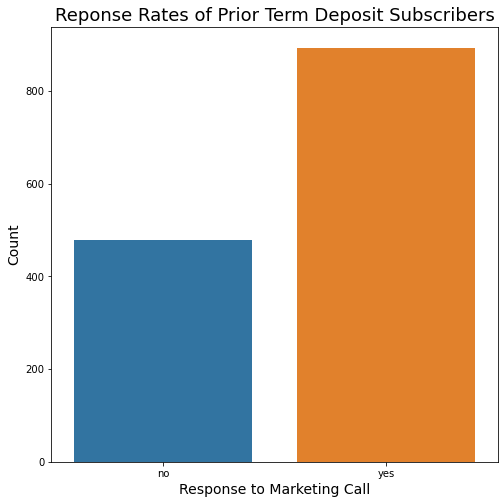

In [20]:
sns.countplot(x = prior_cust['y'])
plt.title("Reponse Rates of Prior Term Deposit Subscribers", fontsize = 18)
plt.xlabel("Response to Marketing Call", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.gcf().set_size_inches(8,8)
plt.show()

Based on the distribution target labels, the directing marketing calls observe a default success rate

### Bivariate Analysis & Feature Selection
For the purpose of exploring the bivariate relationships between predictive features, categorical variables will be one-hot encoded. Findings will not be directly implemented on the working dataframe since this analysis will opt to implement these findings in pipeline.

In this application, the target variable has been re-encoded as y_yes

In [12]:
bank_cat = bank.select_dtypes('object')
bank_num = bank.select_dtypes(['float64', 'int64'])
OH_encoder = OneHotEncoder(drop = 'first', sparse=False)
bank_coded = OH_encoder.fit_transform(bank_cat)
bank_coded = pd.DataFrame(bank_coded, columns = OH_encoder.get_feature_names_out())
bank_coded = pd.concat([bank_coded, bank_num], axis = 1)
bank_coded.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


### Near Zero Variance Analysis

In [13]:
X = bank_coded.drop(columns = ['y_yes'])
y = bank_coded['y_yes']
low_var = VarianceThreshold(threshold=0.1)
low_var.fit(X)
dropcols = [column for column in X.columns
           if column not in
X.columns[low_var.get_support()]]
for features in dropcols:
    print(features)
    
X_highvar = X.drop(dropcols, axis = 1)

job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_unemployed
job_unknown
marital_unknown
education_basic.6y
education_illiterate
education_unknown
default_yes
housing_unknown
loan_unknown
month_dec
month_mar
month_nov
month_oct
month_sep
poutcome_success


Interestingly, many of labels for occupation have very little representation. A similiar situation is noted for the labels of the feature month.

### Multicollinearity Analysis

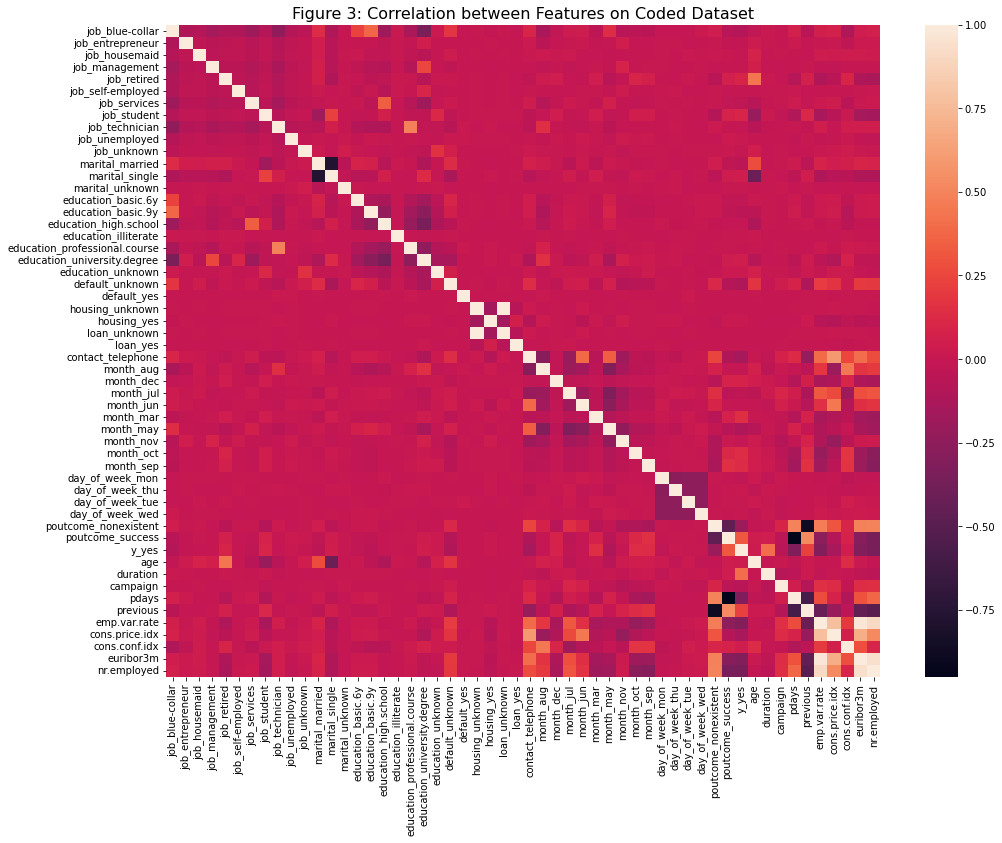

In [14]:
plt.figure(figsize = (16,12))
sns.heatmap(bank_coded.corr())
plt.title("Figure 3: Correlation between Features on Coded Dataset", fontsize = 16)
plt.show()

In [15]:
X_vif = pd.DataFrame()
X_vif['variable'] = X_highvar.columns
X_vif['vif'] = [variance_inflation_factor(X_highvar.values, i)
               for i in range(len(X_highvar.columns))]
# housing_no and loan_no were perfectly correlated with their counterparts so we'll remove them
X_clean = X_highvar #.drop(columns = ['housing_no', 'loan_no'])
X_vif = pd.DataFrame()
X_vif['variable'] = X_clean.columns
X_vif['vif'] = [variance_inflation_factor(X_clean.values, i)
               for i in range(len(X_clean.columns))]
drop = list(X_vif[X_vif['vif']>10].variable)
drop

['poutcome_nonexistent',
 'age',
 'pdays',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

Features of note flagged by VIF analysis include 'age', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', and 'nr.employed'. Modeling using this reduced feature set significantly impacted predictive performance

# Preprocessing and Splitting

Given that this analysis uses pipelines to validate the sub components, all that's necessary in terms of explicit data preparation is partitioning the data into train and test splits, resampling the training set and specifying features into their respective categories for column transformations.

### Data Preparation

In [17]:
# specifying predictive and target features
X = bank.drop(columns = ['y'])
y = bank[['y']]

# encoding target feature labels as 0's and 1's
oe = OrdinalEncoder()
y = oe.fit_transform(y)

In [18]:
# column names
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [19]:
# creating train/test split where test represents the out of sample performance used
# to approximate real world performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

# resampling training set using undersampling
undersampler = RandomUnderSampler(random_state = 123)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [20]:
# categorical features to be used in modeling
cat_variables = ['job', 
                 'marital', 
                 'education', 
                 'default', 
                 'housing', 
                 'loan', 
                 'contact', 
                 'month', 
                 'day_of_week', 
                 'poutcome']
# numeric features to be used in modeling
num_variables = ['age',
                 #'duration', this feature is removed since feature cannot be determined before contact
                 'campaign',
                 'pdays',
                 'previous',
                 'emp.var.rate', 
                 'cons.conf.idx', 
                 'euribor3m', 
                 'nr.employed']

# Modeling

Each model followed a similar pipeline structure to ensure consistent tuning and efficient scaling. Each full pipeline began with a categorical feature pipeline that imputed missing values with the string "Unknown" and then one-hot encoded each feature. Next, our pipeline imputed missing numeric features with the median of the feature in question. Each numeric feature was also standardized based on the training data, except in the case of the k-nearest neighbors model where min-max scaling was used instead. 

Next, the pipeline focused on feature selection. We removed predictors with low variances, tuning the threshold by testing variances 0 to 0.1. We also implemented k-best feature selection into the pipeline, tuning k by testing 1 to 26 predictors. Then the pipeline ends with hyperparameter tuning for the respective model. 

To tune each model, we utilized stratified five-fold cross-validation with a randomized search through each hyperparameter search space. We returned the model with the greatest recall and then created predictions on the test dataset. Finally, we calculated a variety of metrics based on the test data for later comparison.

### k-Nearest Neighbors

Our k-nearest neighbor model was tuned utilizing Scikit-learn's KNeighborsClassifier (Pedregosa et al., 2011). We evaluated using 1 to 25 neighbors and if our weights should be uniform or distance-based. Our optimal hyperparameter values were: 0.1 for the variance minimum, the top 24-best features, 23 neighbors, and distance-based weights. The final model had an accuracy of 76% and a recall of 90% on the test data. 

In [21]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', MinMaxScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)],
                                                                   remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('knn', KNeighborsClassifier(n_jobs = 4))])

In [22]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'knn__weights': ['uniform', 'distance'],
                 'knn__n_neighbors': list(range(1,26,2))}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

knn = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space,
                         n_iter = 500,
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = -1,
                        random_state=123)
knn.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % knn.best_score_)
print(knn.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.1, 'knn__weights': 'uniform', 'knn__n_neighbors': 23, 'k_best__k': 24}


In [23]:
knn_y_pred = knn.predict(X_test)
knn_y_proba = knn.predict_proba(X_test)

In [24]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84      7298
         1.0       0.31      0.90      0.46       940

    accuracy                           0.76      8238
   macro avg       0.64      0.82      0.65      8238
weighted avg       0.91      0.76      0.80      8238



In [25]:
data = [accuracy_score(y_test, knn_y_pred, normalize=True), 
        precision_score(y_test, knn_y_pred),
        recall_score(y_test, knn_y_pred),
        fbeta_score(y_test, knn_y_pred, beta=1),
        roc_auc_score(y_test, knn_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table = pd.DataFrame(data,
                          index = test_names,
                          columns = ['k-NN'])

In [30]:
knn.best_estimator_.classes_

array([0., 1.])

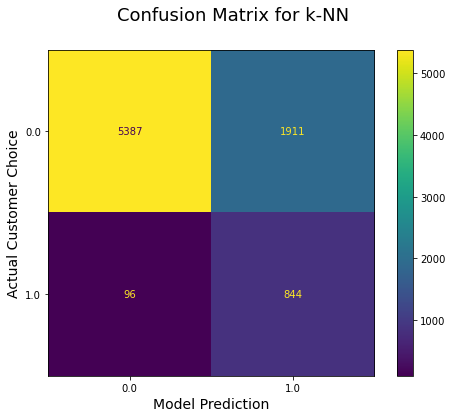

In [40]:
# Confusion matrix to use as example in presenation
cm = confusion_matrix(y_test, knn_y_pred, labels = knn.best_estimator_.classes_)
cmplt = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=knn.best_estimator_.classes_)
cmplt.plot()
plt.suptitle("Confusion Matrix for k-NN", fontsize = 18)
plt.xlabel("Model Prediction", fontsize = 14)
plt.ylabel("Actual Customer Choice", fontsize = 14)
plt.gcf().set_size_inches(8,6)
plt.show()

### Experiment: Validating Resampling Value 

In [25]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

neighbors = list(range(1,26,2))
weight = ['uniform', 'distance']

params = dict(knn__n_neighbors = neighbors,
             knn__weights = weight)

knn_pipe = Pipeline(steps = [('scaler', scaler), ('knn', knn)])

### Neural Networks

We tuned our neural network model using Scikit-learn's MLPClassifier with the 'sgd' solver (Pedregosa et al., 2011). We tuned with two different architectures, the first having three hidden layers with 10, 30, and 10 nodes respectively and the second having one hidden layer comprised of 20 nodes. We tested three different activation functions, ‘relu’, ‘logistic’, and ‘tahn’. L2 regularization was tuned with alpha values ranging from 0.0001 to 0.1. Finally, we tuned the learning rate, comparing a constant to an adaptive learning rate. 

The optimal neural network had a minimum variance of 0.05 and utilized the 21-best features. The single hidden layer architecture, adaptive learning rate, ‘relu’ activation function, and alpha of 0.1 performed the best in cross-validation. The final model had an accuracy of 79% and a recall of 67% on the test data. 



In [26]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)],
                                                                   remainder = 'drop')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('mlp', MLPClassifier(solver = 'sgd'))])

In [27]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'mlp__hidden_layer_sizes': [(10,30,10), (20,)],
                 'mlp__activation': ['relu', 'logistic', 'tanh'], 
                 'mlp__alpha': [0.0001, 0.001, 0.01, 0.1], 
                 'mlp__learning_rate': ['constant', 'adaptive']}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

mlp = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space,
                         n_iter = 200,
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = -1,
                        random_state = 123)
mlp.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % mlp.best_score_)
print(mlp.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.05, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (20,), 'mlp__alpha': 0.1, 'mlp__activation': 'relu', 'k_best__k': 21}


In [28]:
mlp_y_pred = mlp.predict(X_test)
mlp_y_proba = mlp.predict_proba(X_test)

In [29]:
print(classification_report(y_test, mlp_y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      7298
         1.0       0.31      0.67      0.42       940

    accuracy                           0.79      8238
   macro avg       0.63      0.74      0.65      8238
weighted avg       0.88      0.79      0.82      8238



In [30]:
data = [accuracy_score(y_test, mlp_y_pred, normalize=True), 
        precision_score(y_test, mlp_y_pred),
        recall_score(y_test, mlp_y_pred),
        fbeta_score(y_test, mlp_y_pred, beta=1),
        roc_auc_score(y_test, mlp_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['Neural Net'] = data

### XGBoost

We tuned our XGBoost model using XGBoost’s XGBClassifier with the objective ‘binary:logistic’ to solve the model through logistic regression. The model’s tree method parameter was set to ‘GPU_hist’ algorithm. We tuned for the number of trees by setting n_estimator = 50, 100, 150, 200, 250, and 300 to find the optimal amount. The learning rate values were tuned to learning_rate = 0.01, 0.05, 0.1, 0.3, and 1 to determine the step size at each iteration. We tested the max depth of the trees by setting max_depth = 3 ,21 ,2. Different regularization parameters were tuned including alpha, gamma, and lambda. 

Our optimal model had 100 trees with a max depth of 19 and a learning rate equal to 1. The optimal regularization for alpha was 0.3, gamma was 0.4, and lambda was 0.1. The final model for XG Boost had an accuracy of 85% and a recall of 91%. 

Note: You need an NVIDIA GPU to train this model with the gpu_hist option.

In [31]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)],
                                                                   remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('xgBoost', xgb.XGBClassifier(objective="binary:logistic",
                                                        tree_method = 'gpu_hist'))])

In [32]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'xgBoost__n_estimators': [50, 100, 150, 200, 250, 300],
                 'xgBoost__learning_rate': [0.01, 0.1, 0.3, .05, 1],
                 'xgBoost__max_depth': range(3,21,2),
                 'xgBoost__colsample_bytree': [i/10.0 for i in range(3,10)],
                 'xgBoost__gamma': [i/10.0 for i in range(5)],
                 'xgBoost__reg_alpha' : [1e-5, 1e-2, 0.1, .3],
                 'xgBoost__reg_lambda' : [1e-5, 1e-2, 0.1,.3]}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

xgb = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space, 
                         n_iter = 500, 
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = -1,
                        random_state=123)
xgb.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % xgb.best_score_)
print(xgb.best_params_)

Best parameter (CV score=nan):
{'xgBoost__reg_lambda': 0.1, 'xgBoost__reg_alpha': 0.3, 'xgBoost__n_estimators': 100, 'xgBoost__max_depth': 19, 'xgBoost__learning_rate': 1, 'xgBoost__gamma': 0.4, 'xgBoost__colsample_bytree': 0.8, 'nzv__threshold': 0.0, 'k_best__k': 9}


In [33]:
xgb_y_pred = xgb.predict(X_test)
xgb_y_proba = xgb.predict_proba(X_test)

In [34]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7298
         1.0       0.43      0.91      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.85      0.87      8238



In [35]:
data = [accuracy_score(y_test, xgb_y_pred, normalize=True), 
        precision_score(y_test, xgb_y_pred),
        recall_score(y_test, xgb_y_pred),
        fbeta_score(y_test, xgb_y_pred, beta=1),
        roc_auc_score(y_test, xgb_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['XGBoost'] = data

### Experiments: Validating Preprocessing Steps

In [37]:
#model performance without duration and nzv and vif reduced
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7298
         1.0       0.43      0.91      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.85      0.87      8238



In [38]:
#model performance without duration and nzv
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7298
         1.0       0.43      0.91      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.85      0.87      8238



In [39]:
#model performance without duration 
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7298
         1.0       0.43      0.91      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.85      0.87      8238



In [40]:
#model performance with duration included
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7298
         1.0       0.43      0.91      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.92      0.85      0.87      8238



### Extra Trees
Extra Trees

We tuned our extra trees model using Scikit-learn's ExtraTreeClassifier. We tuned different number of trees with n_estimators = 10, 50, 100, 500, 1000, 5000. We also tested the max number of leaf nodes with max_leaf_nodes = 5, 10, 15, 20, 25, 50, and max depths of the trees ranging from 1 to 20. The optimal extra trees had 50 trees and 15 leaf nodes with a max depth of 6. The final model had an accuracy of 77% and a recall of 79% on the test data. 


In [41]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], 
                                                                   remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('etc', ExtraTreesClassifier())])

In [42]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'etc__n_estimators': [10, 50, 100, 500, 1000, 5000],
                 'etc__max_leaf_nodes': [5, 10, 15, 20, 25, 50], 
                 'etc__max_depth': range(2,21,1)}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

etc = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space,
                         n_iter = 200,
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = -1,
                        random_state = 123)
etc.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % etc.best_score_)
print(etc.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.01, 'k_best__k': 7, 'etc__n_estimators': 50, 'etc__max_leaf_nodes': 15, 'etc__max_depth': 6}


In [43]:
etc_y_pred = etc.predict(X_test)
etc_y_proba = etc.predict_proba(X_test)

In [44]:
print(classification_report(y_test, etc_y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.85      7298
         1.0       0.30      0.79      0.44       940

    accuracy                           0.77      8238
   macro avg       0.64      0.78      0.65      8238
weighted avg       0.89      0.77      0.81      8238



In [45]:
data = [accuracy_score(y_test, etc_y_pred, normalize=True), 
        precision_score(y_test, etc_y_pred),
        recall_score(y_test, etc_y_pred),
        fbeta_score(y_test, etc_y_pred, beta=1),
        roc_auc_score(y_test, etc_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['ExtraTrees'] = data

### Logistic Regression
Finally, a logistic regression model was created using Scikit-learn's LogisticRegression with the ‘saga’ solver. We specified three different penalties: ‘l1’, ‘l2’, and ‘elasticnet’ which is both L1 and L2 added together.The parameter C, the inverse of the regularization strength, was tuned with logreg_C = 0.01, 0.1, 0.3, .05, 1. 
The optimal logistic regression parameters used an l1 penalty and a C of one. The final model had an accuracy of 81% and a recall of 64%. 

In [46]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('logreg', LogisticRegression(solver = 'saga'))])

In [47]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'logreg__penalty': ['l1', 'l2', 'elasticnet'],
                 'logreg__C': [0.01, 0.1, 0.3, .05, 1]}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

lr = RandomizedSearchCV(full_pipeline,
                        param_distributions = search_space,
                        n_iter = 200,
                        cv = kfold,
                        scoring ='recall',
                        n_jobs = -1,
                       random_state = 123)
lr.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lr.best_score_)
print(lr.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.0, 'logreg__penalty': 'l1', 'logreg__C': 1, 'k_best__k': 12}


In [48]:
lr_y_pred = lr.predict(X_test)
lr_y_proba = lr.predict_proba(X_test)

In [49]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89      7298
         1.0       0.33      0.64      0.43       940

    accuracy                           0.81      8238
   macro avg       0.64      0.73      0.66      8238
weighted avg       0.88      0.81      0.83      8238



In [50]:
data = [accuracy_score(y_test, lr_y_pred, normalize=True), 
        precision_score(y_test, lr_y_pred),
        recall_score(y_test, lr_y_pred),
        fbeta_score(y_test, lr_y_pred, beta=1),
        roc_auc_score(y_test, lr_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['Logistic Regression'] = data

## Results

In [53]:
# saving test results table
test_table.to_excel('test_table.xlsx')

In [54]:
# printing test results table
test_table

,k-NN,Neural Net,XGBoost,ExtraTrees,Logistic Regression
Accuracy,0.756373,0.789391,0.852756,0.769483,0.809784
Precision,0.306352,0.306003,0.430886,0.304366,0.327842
Recall,0.897872,0.667021,0.905319,0.793617,0.635106
F1,0.456834,0.419538,0.583877,0.439988,0.432452
AUC ROC,0.818010,0.736087,0.875652,0.779996,0.733695


Inspecting the performance metrics of our models on the test split presents a few interesting findings. In terms of model accuracy, XGBoost, Logistic Regression, and the Neural Network observe strong performance, achieving accuracies of 85.3%, 80.9%, and 78.9%, respectively. The models begin to diverge in terms of viability once we begin to look at recall with XGBoost and k-Nearest Neighbors performing significantly better than all other models with recalls of 90.5% and 89.8%. Inspection of the remaining statistics appears to create the image that XGBoost is outperforming all other models. This will be additionally verified by plotting the AUC-ROC curves of each model.

### AUC-ROC

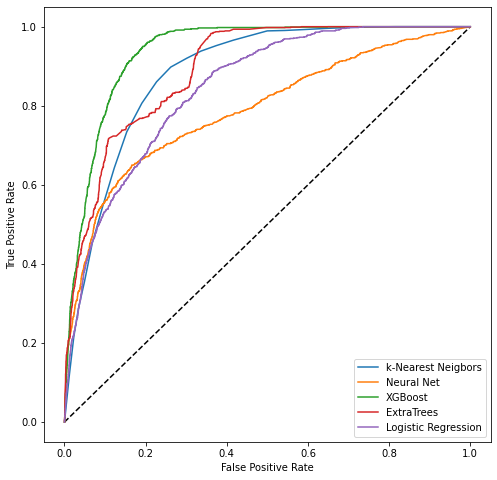

In [55]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_y_proba[:,1])
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, mlp_y_proba[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_y_proba[:,1])
fpr_etc, tpr_etc, thresholds_etc = roc_curve(y_test, etc_y_proba[:,1])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_y_proba[:,1])

plt.figure(figsize = (8, 8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_knn, tpr_knn, label = 'k-Nearest Neigbors')
plt.plot(fpr_mlp, tpr_mlp, label = 'Neural Net')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost')
plt.plot(fpr_etc, tpr_etc, label = 'ExtraTrees')
plt.plot(fpr_lr, tpr_lr, label = 'Logistic Regression')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Inspection of the ROC curves indicates that while XGBoost does outperform all other models, k-Nearest neighbors is the obvious second-best-performing model that closely mimics the form of XGBoost. Given that the final implementation can depend on interpretability as well as performance, both models will be included as viable options for increasing the efficiency of direct marketing calls.


### Gain and Lift Charts for Selected Models

With final models chosen, this analysis can create and inspect the cumulative gain charts as well as lift charts.

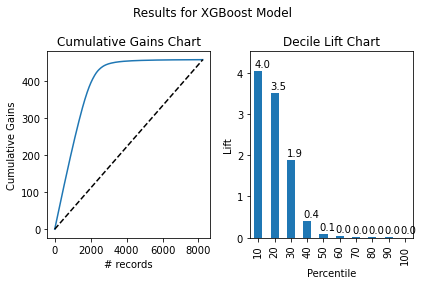

In [56]:
neg, pos = zip(*xgb_y_proba)
xg_probs = pd.Series(pos)
xg_probs_adj = xg_probs * (11.52/50)
xg_probs_sort = xg_probs_adj.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(xg_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(xg_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for XGBoost Model")
plt.tight_layout()
plt.show()

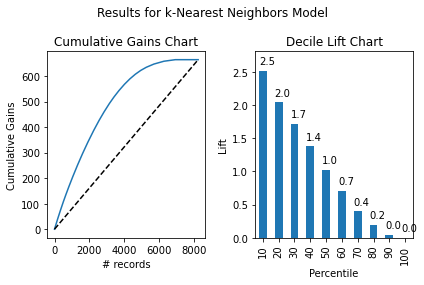

In [57]:
neg, pos = zip(*knn_y_proba)
knn_probs = pd.Series(pos)
knn_probs_adj = knn_probs * (11.52/50)
knn_probs_sort = knn_probs_adj.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(knn_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(knn_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for k-Nearest Neighbors Model")
plt.tight_layout()
plt.show()

After adjusting for resampling, we evaluated the two top models in gains and lift charts. The XGBoost was again the top performer. The model’s gains chart reached its peak much sooner than the k-Nearest Neighbors and it had substantially higher lifts within the top 30th percentile than the k-NN. 

## Discussion

The goal of this data mining process was to identify a model in which subscriptions for bank term deposits could be effectively predicted. Finding an optimal model could be pivotal in helping banks improve their marketing campaign efforts and properly target the right group of customers. Using the bank marketing dataset collected by the Portuguese bank, our team could analyze, pre-process, feature select, and build models that can predict the outcome of customers subscribing to bank term deposits. The models that were evaluated and tuned were K Nearest Neighbors, Neural Networks, XG Boost, Extra Trees and Logistic Regression. After model evaluation and metrics comparison, the final two models with the best performance were XG Boost and KNN. The XG Boost model had higher recall, accuracy, precision, F1-score, and AUC ROC. The higher AUC score was a determining factor for best model performance given that XG Boost had more true positive predictions than the rest of the models. When comparing models based on the cumulative gains chart, XG Boost outperformed as well by reaching its maximum at 2,000 observations. These results suggest that the bank marketing campaign can target less people (and reduce costs) to reach similar results when compared to the KNN model which reached its maximum at almost 4,000 observations. For future steps, the model should be tested and evaluated on other bank marketing campaign datasets to further tune and assess the model’s performance. 

#### Archived Experimental Accuracy Plots

In [ ]:
Results_acc = Results_saved.sort_values(by=['Accuracy'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotac = sns.barplot(y = 'Model', x = 'Accuracy', hue = 'Data Used', data = Results_acc, dodge=False,
            palette = {'Unbalanced' : 'tab:orange', 'Undersampled': 'tab:green', 'Undersampled + KBest': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('Accuracy',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
legend = plt.legend(loc = 'lower right', title = 'Data Used', fontsize = 14)
plt.setp(legend.get_title(), fontsize = 20)
plt.show()

In [ ]:
Results_f1 = Results_saved.sort_values(by=['F1 Score'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotf1 = sns.barplot(y = 'Model', x = 'F1 Score', hue = 'Data Used', data = Results_f1, dodge=False,
            palette = {'Unbalanced' : 'tab:orange', 'Undersampled': 'tab:green', 'Undersampled + KBest': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('F1 Score',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
plt.setp(plotf1.get_legend().get_texts(), fontsize = 14)
plt.setp(plotf1.get_legend().get_title(), fontsize = 20)
plt.show()